# Treinamento e validação de Modelos - Dataset FakeRecogna
Treinamento de um modelo usando como base o segundo dataset estudado: https://github.com/Gabriel-Lino-Garcia/FakeRecogna 

Após verificar que o primeiro modelo obteve uma performace ruim ao ser testado com outro dataset, fez-se a hipótese de que isto pode ter ocorrido devido à baixa variabilidade de notícias no primeiro dataset utilizado. Optou-se então por tentar treinar um modelo TF-IDF no segundo dataset, que possui maior variedade de notícias, para validar se isto resultaria em um modelo mais geral.

Este modelo, além de ser validado no próprio dataset que o gerou, também é validado com o primeiro dataset utilizado no projeto.

In [1]:
# Se necessário
%pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sagemaker
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score
from python_scripts.save_load import load_df_from_bucket, save_df_to_s3_bucket, save_to_s3_bucket_as_libsvm, BUCKET_MODEL
from python_scripts.modelling import create_train_validation_test_sets, setup_model, make_prediction
from python_scripts.plots import plot_confusion_matrix

## Carregamento de dados
O pré-processamento e padronização dos dados deste dataset já foi realizado no notebook `preprocessing.ipynb`.

In [3]:
model_df = load_df_from_bucket('dados_processados_recogna.csv', tipo='processado')
model_df.head()

,Categoria,lemmas_str,fake
0,entretenimento,apagão vaticano papar presar acusação tráfico ...,1
1,saúde,governar equador anunciar preparar cova coleti...,0
2,saúde,companhia air france operar voar direto pequim...,0
3,saúde,marfrig global foods retomar vender carnar bov...,0
4,entretenimento,assunto voltar compartilhar rede social julho ...,1


## Modelo 1: TF-IDF baseado no texto da notícia
Vetorização TF-IDF é aplicada somente à coluna de texto da notícia. Demais colunas de dados não são consideradas.

In [4]:
train_1, test_1, validate_1 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.2, random_state=42)

### Processamento adicional

Um vetorizador TFIDF é utilizado para converter os dados textuais em colunas do DataFrame.

In [5]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_1['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [6]:
def create_x_y_1(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res, base_df[target_col]

x_train_1, y_train_1 = create_x_y_1(train_1, tfidf)
x_validate_1, y_validate_1 = create_x_y_1(validate_1, tfidf)
x_test_1, y_test_1 = create_x_y_1(test_1, tfidf)

### Upload de dados para o S3

In [7]:
file_name_tuples = [(x_train_1, y_train_1, 'train'), 
                   (x_test_1, y_test_1, 'test'), 
                   (x_validate_1, y_validate_1, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_1_2.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Treinar modelo

In [8]:
xgb_model_1, data_channels_1 = setup_model(base_image='xgboost', model_name='model_1_2', instance_count=4, 
                                           instance_type='ml.m4.xlarge')
xgb_model_1.fit(inputs=data_channels_1)

print('ready for hosting!')

2022-11-16 13:26:31 Starting - Starting the training job...ProfilerReport-1668605191: InProgress
...
2022-11-16 13:27:06 Starting - Preparing the instances for training.........
2022-11-16 13:28:56 Downloading - Downloading input data......
2022-11-16 13:29:54 Training - Downloading the training image.....[2022-11-16 13:30:40.395 ip-10-0-239-65.ec2.internal:8 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-16:13:30:40:INFO] Imported framework sagemaker_xgboost_container.training
[2022-11-16:13:30:40:INFO] Failed to parse hyperparameter eval_metric value map to Json.
Returning the value itself
[2022-11-16:13:30:40:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-11-16:13:30:40:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-16:13:30:40:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-11-16:13:30:40:INFO] files path: /opt/ml/input/data/train
[2022-11-16:13:30:40:INFO] files path: /opt/ml/inp

In [9]:
xgb_predictor_1 = xgb_model_1.deploy(initial_instance_count=1,
                                     serializer=sagemaker.serializers.LibSVMSerializer(),
                                     instance_type='ml.m4.xlarge')

-------!

### Métricas do modelo

In [10]:
y_pred_1 = make_prediction(xgb_predictor_1, model_name='model_1_2')

# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_alt = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_1_2.csv')

In [11]:
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       595
           1       0.86      0.93      0.90       595

    accuracy                           0.89      1190
   macro avg       0.90      0.89      0.89      1190
weighted avg       0.90      0.89      0.89      1190



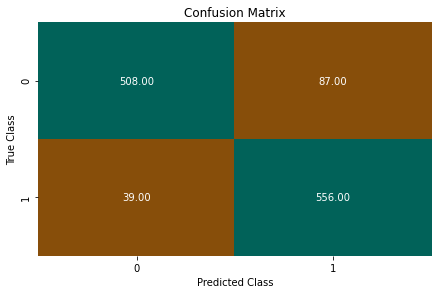

In [12]:
plot_confusion_matrix(y_test_1, y_pred_1)

In [13]:
precision_score(y_test_1, y_pred_1)

0.864696734059098

Verifica-se aqui um excelente desempenho mesmo com os dados separados para teste, como foi visto no notebook `model_fakebr.ipynb`para o dataset Fake.br-Corpus. Em seguida, será feita uma segunda validação utilizando este dataset.

### Salvar predição

In [14]:
df_pred_alt = pd.DataFrame({'pred_1_2': y_pred_1})
df_pred_alt.to_csv(f's3://{BUCKET_MODEL}/test/pred_1_2.csv', encoding='utf-8', index=False)

## Teste adicional - Dataset Fake.br-Corpus
Serão amostradas 800 notícias do Dataset Fake.br-Corpus para uma segunda validação do presente modelo.

### Carregar dataset e amostrar dados

In [15]:
alternative_df = load_df_from_bucket('dados_processados.csv', tipo='processado')
alternative_df.head()

,fake,text,avg_sent_len,avg_word_len,words_str,lemmas_str
0,0,A divisão do STF ao meio entre partidários e ...,10.504673,6.785107,divisão STF meio partidários independentes fic...,divisão STF meio partidário independente ficar...
1,1,"General manda recado para STF: ""Abaixaram as c...",10.866667,6.502610,General manda recado STF Abaixaram calças Cong...,general mandar recado STF abaixar calça congre...
2,1,O Nordeste acordou! Lula e o PT são enxotados:...,7.333333,6.565873,Nordeste acordou Lula PT enxotados Chega bande...,nordeste acordar Lula PT enxotar chegar bandei...
3,0,"Dois relatórios da Polícia Federal, com análi...",16.878788,7.286668,Dois relatórios Polícia Federal análises mater...,dois relatório Polícia Federal análise materia...
4,1,Coreia do Norte declara status de QUASE-GUERRA...,11.600000,6.531320,Coreia Norte declara status QUASE-GUERRA mobil...,Coreia Norte declarar status QUASE-GUERRA mobi...


In [16]:
alternative_df = alternative_df[['fake', 'lemmas_str']]
alternative_df.head()

,fake,lemmas_str
0,0,divisão STF meio partidário independente ficar...
1,1,general mandar recado STF abaixar calça congre...
2,1,nordeste acordar Lula PT enxotar chegar bandei...
3,0,dois relatório Polícia Federal análise materia...
4,1,Coreia Norte declarar status QUASE-GUERRA mobi...


In [17]:
sample_df = alternative_df.sample(n=800, random_state=42)

#### Predição

Aplicar TF-IDF para vetorizar, salvar dados no S3 e efetuar predição

In [18]:
x_test_alt, y_test_alt = create_x_y_1(sample_df, tfidf)

In [19]:
save_to_s3_bucket_as_libsvm(x_test_alt, y_test_alt, 
                            prefix='test', filename='model_2_1_alt.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [20]:
y_pred_alt = make_prediction(xgb_predictor_1, model_name='model_2_1_alt')

# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_alt = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_2_alt.csv')

## Métricas

In [21]:
print(classification_report(y_test_alt, y_pred_alt))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       373
           1       0.89      0.59      0.71       427

    accuracy                           0.74       800
   macro avg       0.78      0.75      0.74       800
weighted avg       0.78      0.74      0.74       800



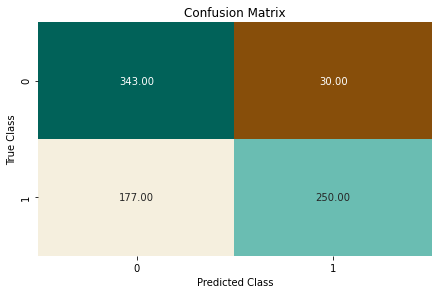

In [22]:
plot_confusion_matrix(y_test_alt, y_pred_alt)

In [24]:
precision_score(y_test_alt, y_pred_alt)

0.8928571428571429

Ao se avaliar o modelo com o dataset Fake.br-Corpus, verifica-se uma precisão ainda maior do que a obtida com o set de teste do dataset FakeRecogna, utilizado no treinamento do modelo. Todavia, é necessário atentar-se ao aumento considerável de falsos negativos neste teste, que leva a valores menores de recall (0.59 neste teste, contra 0.93 no conjunto de testes do FakeRecogna) e F1-score (0.71 vs 0.90). O modelo aqui obtido prefere classificar as notícias como verdadeiras quando são muito diferentes do dataset utilizado no treinamento.

Um modelo combinado, treinado baseado nos dois datasets, é apresentado no notebook `model_combinado.ipynb`.

#### Salvar predição

In [25]:
df_pred_alt = pd.DataFrame({'pred_2_alt': y_pred_alt})
df_pred_alt.to_csv(f's3://{BUCKET_MODEL}/test/pred_2_alt.csv', encoding='utf-8', index=False)

### Encerrar modelo
Após pegar métricas e dados de interesse, encerrar modelo para evitar cobranças.

In [26]:
xgb_predictor_1.delete_endpoint(delete_endpoint_config=True) 